In [6]:
# Install colab_ssh on google colab
!pip install colab_ssh --upgrade

from colab_ssh import launch_ssh
launch_ssh('21v23nE9rkUZAwWwJZ1zAxGLuwK_7v2uhNRStUAsGmaEtCm5D', 'ml')


we highly recommend that update your code by following this documentation https://github.com/WassimBenzarti/colab-ssh#getting-started
Successfully running 2.tcp.ngrok.io:18170
[Optional] You can also connect with VSCode SSH Remote extension using this configuration:

  Host google_colab_ssh
    HostName 2.tcp.ngrok.io
    User root
    Port 18170
    


In [2]:
%%capture
! pip install kaggle ; mkdir ~/.kaggle ; cp /content/kaggle.json ~/.kaggle ; kaggle datasets download moltean/fruits ; unzip fruits.zip ; pip install visualkeras # module for CNN visualization

In this section of the project I will use the VGG16 Architecture to make predictions again, this architecture is simple and widely used, It's not state of the art but it should be good enough to experiment with.

## Loading the data and Transfer Learning test (VGG16)

In [3]:
# Loading the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
import visualkeras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


# loading image modules
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#matplotlib styles
plt.style.use(['ggplot'])

In [4]:
conv_base = keras.applications.vgg16.VGG16(
                          weights="imagenet",
                          include_top=False,
                          input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


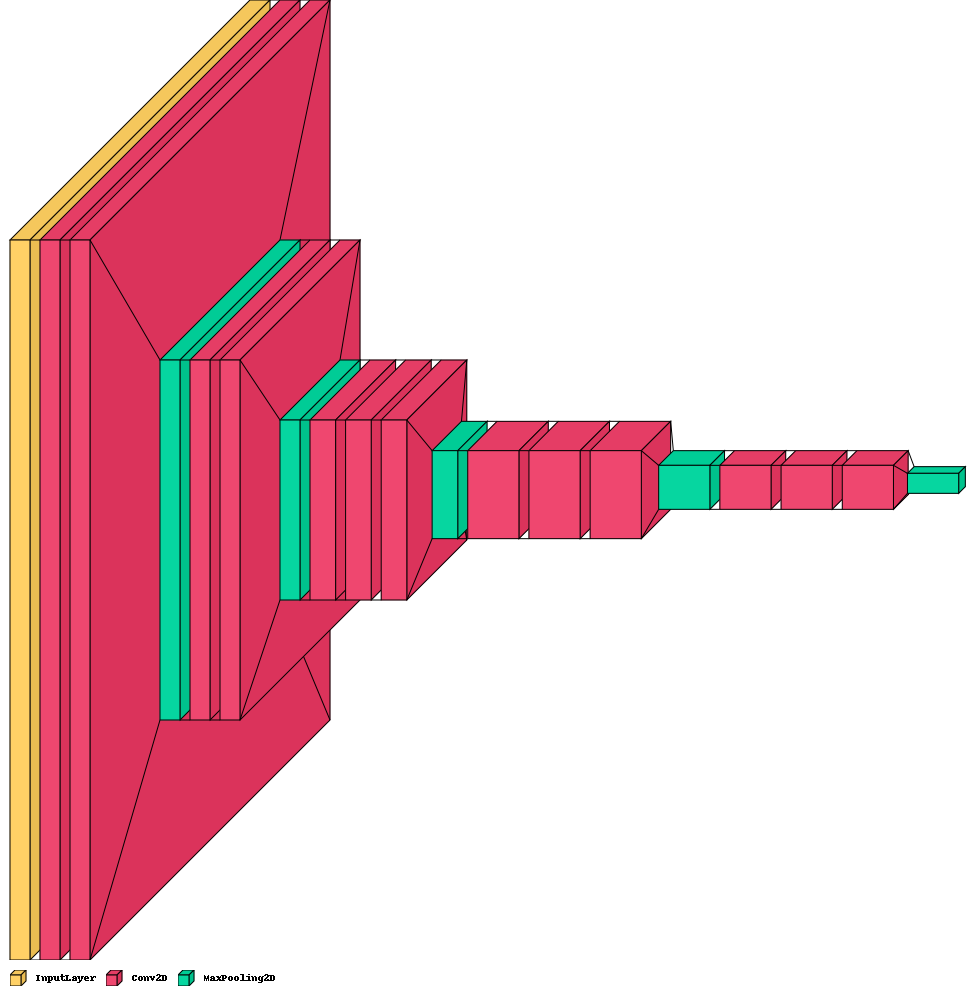

In [5]:
visualkeras.layered_view(conv_base).show()
visualkeras.layered_view(conv_base,legend=True)

In [ ]:
conv_base.summary() # Print a Summary of the VGG-16 Architecture 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

## Extracting features using this pretrained convolutional base

In [ ]:
train_dir = '/content/fruits-360_dataset/fruits-360/Training'
test_dir = '/content/fruits-360_dataset/fruits-360/Test'


In [ ]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #split for validation
    validation_split=0.2)

train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    shuffle=True,# IMPORTANT , shuffle the dataset
    subset='training'# set as training data
)

val_ds = train_gen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(100, 100),
    batch_size=32,
    subset='validation') # set as validation data


test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    shuffle=True
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:

from keras import models,layers,optimizers

conv_base.trainable = False # Freeze the convolutional base 

model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(131, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),       
              loss='categorical_crossentropy',
              metrics=['acc']
              )
history = model.fit(train_ds,
                    epochs=30,
                    batch_size=20,
                    validation_data=val_ds)
                    
                    

Epoch 1/30


ValueError: ignored